# Brain Stroke prediction

In [130]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix,\
  ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

SEED = 42

## Loading data

In [131]:
!gdown 14RnHkHVRmZHdXF7_THt7arQzlzplKbF1

Downloading...
From: https://drive.google.com/uc?id=14RnHkHVRmZHdXF7_THt7arQzlzplKbF1
To: /content/heart.csv
100% 11.3k/11.3k [00:00<00:00, 16.4MB/s]


In [132]:
df_raw = pd.read_csv('heart.csv')
df_raw.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data preprocessing and analysis

In [133]:
df_raw.info() # only int and float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [134]:
print(df_raw.shape) # 303 observations, 14 variables (including one output class)
df_raw.describe()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Based on the data and documentation from kaggle we should apply one-hot encoding transformation to the following variables: `cp`, `restecg`.

In [135]:
df = pd.get_dummies(df_raw, columns=['cp', 'restecg'])
df.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,0,1,1,0,0,0,1,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,2,1,0,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,2,1,0,1,0,0,1,0,0
3,56,1,120,236,0,178,0,0.8,2,0,2,1,0,1,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,2,1,1,0,0,0,0,1,0


In [136]:
df.isnull().values.any() # no missing values

False

In [137]:
np.unique(df.output, return_counts=True) # quite balanced set

(array([0, 1]), array([138, 165]))

In [138]:
X = df.drop('output', axis=1)
y = df.output

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

With stratify argument we can assure than the proportion of values in the sample produced will be the same as the proportion of values in `y`.

Also, I decided to standardize features by removing the mean and scaling to unit variance. We don't want a feature that has a variance that is orders of magnitude larger than others.

For now I will use just train/test split, in the future I can extend it with train/val/test split if needed.

## Logistic regression

In [146]:
LR_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED).fit(X_train, y_train)

In [147]:
LR_pred = LR_model.predict(X_test)
LR_pred_prob = LR_model.predict_proba(X_test)[:, 1] # only probs of positive cases
print(f'Acc = {accuracy_score(y_test, LR_pred).round(3)}')
print(f'AUC = {roc_auc_score(y_test, LR_pred_prob).round(3)}')
print(f'F1 = {f1_score(y_test, LR_pred).round(3)}')
print(f'Recall = {recall_score(y_test, LR_pred).round(3)}')
print(f'Precision = {precision_score(y_test, LR_pred).round(3)}')

Acc = 0.787
AUC = 0.873
F1 = 0.817
Recall = 0.879
Precision = 0.763


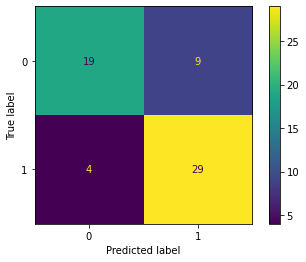

In [142]:
cm = confusion_matrix(y_test, LR_pred, labels=LR_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR_model.classes_)
disp.plot()

## XGBoost

In [148]:
BST_model = xgb.XGBClassifier(random_state=SEED).fit(X_train, y_train)

In [149]:
BST_pred = BST_model.predict(X_test)
BST_pred_prob = BST_model.predict_proba(X_test)[:, 1] # only probs of positive cases
print(f'Acc = {accuracy_score(y_test, BST_pred).mean().round(3)}')
print(f'AUC = {roc_auc_score(y_test, BST_pred_prob).round(3)}')
print(f'F1 = {f1_score(y_test, BST_pred).round(3)}')
print(f'Recall = {recall_score(y_test, BST_pred).round(3)}')
print(f'Precision = {precision_score(y_test, BST_pred).round(3)}')

Acc = 0.803
AUC = 0.868
F1 = 0.833
Recall = 0.909
Precision = 0.769


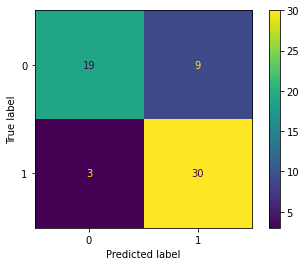

In [150]:
cm = confusion_matrix(y_test, BST_pred, labels=BST_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=BST_model.classes_)
disp.plot()

To sum up, performance of these two methods is comparable, logistic regression looks sligthly worse according to most metrics.